# Demo Program: K-Means Clustering pada Dataset UNSW-NB15

Notebook ini dirancang khusus untuk **demo** — setiap cell berisi penjelasan (markdown) yang menjelaskan tujuan cell, kode, dan interpretasi output yang diharapkan. Jalankan cell satu per satu (Shift+Enter).

## 1) Import library & cek environment

Pastikan Anda memasang paket yang diperlukan: numpy, pandas, scikit-learn, matplotlib, seaborn, jupyter.

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

print('Python version:', sys.version)
print('numpy:', np.__version__)
print('pandas:', pd.__version__)
%matplotlib inline
plt.style.use('ggplot')


Python version: 3.14.0 (tags/v3.14.0:ebf955d, Oct  7 2025, 10:15:03) [MSC v.1944 64 bit (AMD64)]
numpy: 2.4.2
pandas: 3.0.0


## 2) Load dataset

Ubah PATH jika lokasi file CSV berbeda.

In [3]:
PATH = 'UNSW_NB15_training-set.csv'

df = pd.read_csv(PATH)
print('Jumlah data:', df.shape)
df.head()

Jumlah data: (175341, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


## 3) Struktur dataset & pengecekan missing value

Periksa tipe kolom dan missing value.

In [4]:
df.info()

missing = df.isnull().sum().sort_values(ascending=False)
missing[missing>0]


<class 'pandas.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  str    
 3   service            175341 non-null  str    
 4   state              175341 non-null  str    
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  sinpkt       

Series([], dtype: int64)

## 4) Seleksi fitur numerik 

Hanya fitur numerik yang dipakai untuk K-Means.

In [5]:
numeric_features = df.select_dtypes(include=[np.number]).copy()
for c in ['id','label']:
    if c in numeric_features.columns:
        numeric_features.drop(columns=c, inplace=True)
print('Feature count:', numeric_features.shape[1])
numeric_features.columns.tolist()[:40]


Feature count: 39


['dur',
 'spkts',
 'dpkts',
 'sbytes',
 'dbytes',
 'rate',
 'sttl',
 'dttl',
 'sload',
 'dload',
 'sloss',
 'dloss',
 'sinpkt',
 'dinpkt',
 'sjit',
 'djit',
 'swin',
 'stcpb',
 'dtcpb',
 'dwin',
 'tcprtt',
 'synack',
 'ackdat',
 'smean',
 'dmean',
 'trans_depth',
 'response_body_len',
 'ct_srv_src',
 'ct_state_ttl',
 'ct_dst_ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_flw_http_mthd',
 'ct_src_ltm',
 'ct_srv_dst',
 'is_sm_ips_ports']

### 4.1 Quick statistics

Ringkasan statistik beberapa fitur.

In [6]:
numeric_features.describe().T[['mean','std','min','25%','50%','75%','max']].head(12)


,mean,std,min,25%,50%,75%,max
dur,1.359389e+00,6.480249e+00,0.0,0.000008,0.001582,6.680690e-01,5.999999e+01
spkts,2.029866e+01,1.368876e+02,1.0,2.000000,2.000000,1.200000e+01,9.616000e+03
dpkts,1.896959e+01,1.102583e+02,0.0,0.000000,2.000000,1.000000e+01,1.097400e+04
sbytes,8.844844e+03,1.747656e+05,28.0,114.000000,430.000000,1.418000e+03,1.296523e+07
dbytes,1.492892e+04,1.436542e+05,0.0,0.000000,164.000000,1.102000e+03,1.465555e+07
rate,9.540619e+04,1.654010e+05,0.0,32.786140,3225.806520,1.250000e+05,1.000000e+06
sttl,1.795470e+02,1.029400e+02,0.0,62.000000,254.000000,2.540000e+02,2.550000e+02
dttl,7.960957e+01,1.105069e+02,0.0,0.000000,29.000000,2.520000e+02,2.540000e+02
sload,7.345403e+07,1.883574e+08,0.0,13053.338870,879674.750000,8.888889e+07,5.988000e+09
dload,6.712056e+05,2.421312e+06,0.0,0.000000,1447.022705,2.784487e+04,2.242273e+07


## 5) Imputasi (median) & Normalisasi (StandardScaler)

In [7]:
imp = SimpleImputer(strategy='median')
X_imputed = imp.fit_transform(numeric_features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_features.columns)
print('Scaled shape:', X_scaled_df.shape)
X_scaled_df.head()


Scaled shape: (175341, 39)


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,-0.191029,-0.104456,-0.135769,-0.049134,-0.102726,-0.576371,0.703839,1.578100,-0.389897,-0.273700,...,-0.645013,-0.544736,-0.554373,-0.705529,-0.118590,-0.118590,-0.189768,-0.715714,-0.753074,-0.126508
1,-0.109485,-0.046014,0.172599,-0.046410,0.188544,-0.576345,-1.141901,1.560002,-0.389928,-0.069233,...,-0.645013,-0.544736,-0.554373,-0.614256,-0.118590,-0.118590,-0.189768,-0.715714,-0.288257,-0.126508
2,0.040699,-0.089845,-0.026933,-0.048527,-0.012133,-0.576734,-1.141901,1.560002,-0.389964,-0.252044,...,-0.520827,-0.544736,-0.554373,-0.522983,-0.118590,-0.118590,-0.189768,-0.595543,-0.288257,-0.126508
3,0.049729,-0.060624,-0.063212,-0.047016,-0.098563,-0.576737,-1.141901,1.560002,-0.389958,-0.275821,...,-0.520827,-0.544736,-0.554373,-0.522983,7.814915,7.814915,-0.189768,-0.595543,-0.753074,-0.126508
4,-0.140417,-0.075235,-0.117630,-0.047554,-0.102057,-0.576617,0.723268,1.560002,-0.389927,-0.275561,...,-0.520827,-0.420468,-0.554373,2.854115,-0.118590,-0.118590,-0.189768,-0.595543,2.779535,-0.126508


## 6) Auto‑K — Elbow Method (Inertia/SSE)

Hitung inertia untuk K=2..6 dan tampilkan tabel serta plot.

 K      inertia
 2 5.482519e+06
 3 4.795762e+06
 4 4.393975e+06
 5 4.066431e+06
 6 3.954483e+06


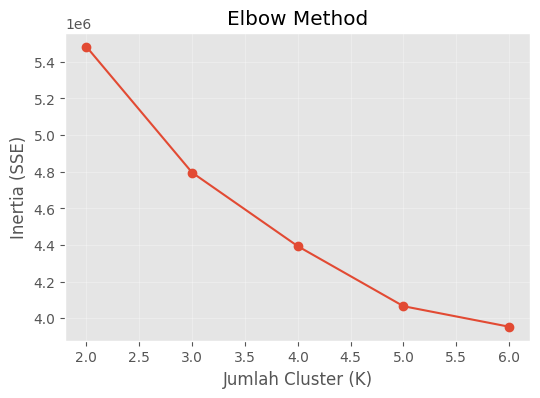

In [8]:
from sklearn.cluster import MiniBatchKMeans
K_range = range(2,7)
iner = []
for k in K_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000, n_init=10)
    kmeans.fit(X_scaled_df)
    iner.append(kmeans.inertia_)

inertia_table = pd.DataFrame({'K': list(K_range), 'inertia': iner})
print(inertia_table.to_string(index=False))
plt.figure(figsize=(6,4))
plt.plot(list(K_range), iner, marker='o')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method')
plt.grid(alpha=0.3)
plt.show()


## 7) Auto‑K — Silhouette Score (sampled)

Sampling for efficiency (n~2000).

 K  silhouette
 2    0.308072
 3    0.242171
 4    0.332543
 5    0.218905
 6    0.339507


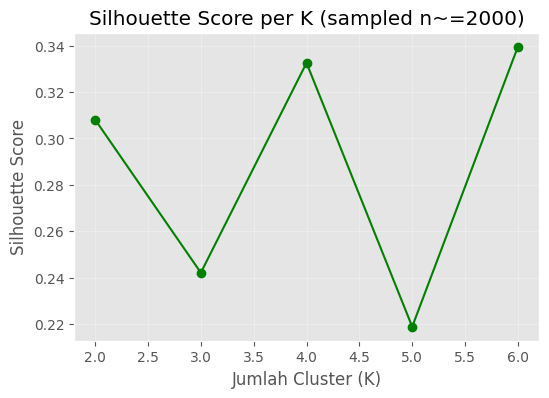

In [9]:
from sklearn.metrics import silhouette_score
from sklearn.utils import resample
X_sample = resample(X_scaled_df, n_samples=min(2000, len(X_scaled_df)), random_state=42)

silhouette_scores = []
for k in K_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000, n_init=10)
    labels_s = kmeans.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels_s)
    silhouette_scores.append(score)

sil_table = pd.DataFrame({'K': list(K_range), 'silhouette': silhouette_scores})
print(sil_table.to_string(index=False))
plt.figure(figsize=(6,4))
plt.plot(list(K_range), silhouette_scores, marker='o', color='green')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score per K (sampled n~=2000)')
plt.grid(alpha=0.3)
plt.show()


## 8) Pilih K optimal & fit final

Atur `K_opt` (contoh: 2) lalu fit final model.

In [10]:
K_opt = 2
final_kmeans = MiniBatchKMeans(n_clusters=K_opt, random_state=42, batch_size=1000, n_init=10)
labels = final_kmeans.fit_predict(X_scaled_df)
df['cluster'] = labels.astype('int32')
print(df['cluster'].value_counts().sort_index())


cluster
0    96179
1    79162
Name: count, dtype: int64


## 9) Sample data dengan cluster

Tampilkan beberapa baris asli dengan kolom cluster dan beberapa fitur penting.

In [11]:
sample_cols = ['cluster'] + list(numeric_features.columns[:8])
df[sample_cols].head(12)


,cluster,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl
0,1,0.121478,6,4,258,172,74.087490,252,254
1,1,0.649902,14,38,734,42014,78.473372,62,252
2,1,1.623129,8,16,364,13186,14.170161,62,252
3,1,1.681642,12,12,628,770,13.677108,62,252
4,1,0.449454,10,6,534,268,33.373826,254,252
5,1,0.380537,10,6,534,268,39.417980,254,252
6,1,0.637109,10,8,534,354,26.683033,254,252
7,0,0.521584,10,8,534,354,32.593026,254,252
8,1,0.542905,10,8,534,354,31.313031,254,252
9,1,0.258687,10,6,534,268,57.985135,254,252


## 10) Crosstab cluster vs label (interpretasi)

Gunakan crosstab untuk melihat korelasi antara cluster (unsupervised) dan label asli (hanya untuk interpretasi).

In [12]:
ct = pd.crosstab(df['cluster'], df['label'], normalize='index')
(ct*100).round(2)


label,0,1
cluster,,
0,18.37,81.63
1,48.42,51.58


## 11) Fitur teratas yang membedakan cluster

Jika K=2, hitung selisih absolut rata-rata antar cluster dan tampilkan top-10 fitur.

In [13]:
cluster_means = df.groupby('cluster')[numeric_features.columns].mean()
if cluster_means.shape[0] == 2:
    absdiff = (cluster_means.loc[0] - cluster_means.loc[1]).abs()
    top_features = absdiff.sort_values(ascending=False).head(10)
    print('Top 10 features by absolute mean difference between cluster 0 and 1:')
    display(top_features)
else:
    print('K != 2: gunakan pendekatan ranking fitur lain untuk K>2')


Top 10 features by absolute mean difference between cluster 0 and 1:


stcpb                2.146536e+09
dtcpb                2.145791e+09
sload                1.330894e+08
dload                1.329924e+06
rate                 1.723604e+05
dbytes               3.298577e+04
sbytes               1.790902e+04
sjit                 1.078431e+04
response_body_len    4.749529e+03
sinpkt               1.517814e+03
dtype: float64

## 12) Visualisasi fitur teratas (opsional)

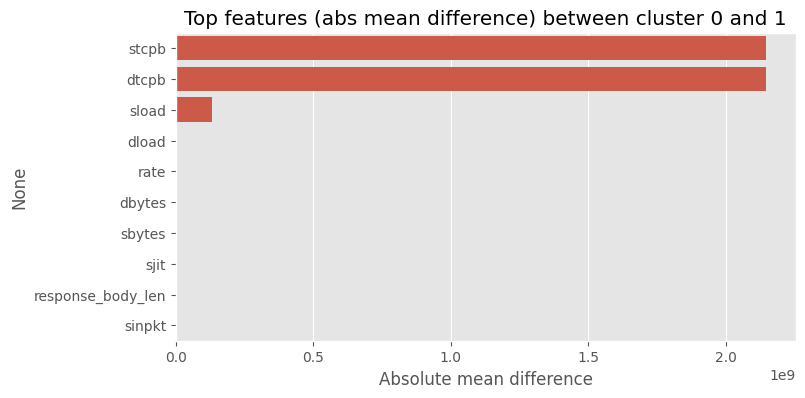

In [14]:
try:
    top_feats = top_features.index.tolist()
    plt.figure(figsize=(8,4))
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title('Top features (abs mean difference) between cluster 0 and 1')
    plt.xlabel('Absolute mean difference')
    plt.show()
except Exception as e:
    print('Jalankan cell sebelumnya untuk menentukan top_features terlebih dahulu.', e)


## 13) Simpan artefak (opsional)

Simpan tabel dan label cluster ke CSV untuk disertakan ke laporan atau diunggah.

In [16]:
from pathlib import Path
from datetime import datetime

# folder name: YYYYMMDD_HHMM
out_dir = Path(datetime.now().strftime("%Y%m%d_%H%M"))
out_dir.mkdir(parents=True, exist_ok=True)

inertia_table.to_csv(out_dir / 'inertia_table.csv', index=False)
sil_table.to_csv(out_dir / 'silhouette_table.csv', index=False)
df[['cluster']].to_csv(out_dir / 'unsw_clustered_labels.csv', index=False)
try:
    top_features.to_csv(out_dir / 'top_features_absdiff.csv')
except:
    pass

print(f"Saved outputs to folder: {out_dir}")

Saved outputs to folder: 20260202_0203


In [ ]:
# cek apakah id/label masuk sebagai fitur numerik
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns count:", len(num_cols))
print("Is 'id' in numeric cols? ", 'id' in num_cols)
print("Is 'label' in numeric cols? ", 'label' in num_cols)


## 5. Analisis Hasil Clustering (Demo & Interpretasi)

### 5.1 Distribusi Jumlah Data per Cluster

In [ ]:
# counts & percent
counts = df['cluster'].value_counts().sort_index()
percents = (counts / counts.sum() * 100).round(2)
pd.DataFrame({'count': counts, 'percent (%)': percents})

### 5.2 Karakteristik Rata-rata Cluster (Centroid pada Skala Asli)

In [ ]:
centers_scaled = final_kmeans.cluster_centers_
centers_unscaled = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_unscaled, columns=numeric_features.columns)
centers_df.index.name = 'cluster'
centers_df.round(2)

### 5.3 Fitur Paling Membedakan Antar Cluster (Skala Standardized)

In [ ]:
cluster_means_scaled = pd.DataFrame(final_kmeans.cluster_centers_, columns=numeric_features.columns)
if cluster_means_scaled.shape[0] == 2:
    absdiff_std = (cluster_means_scaled.loc[0] - cluster_means_scaled.loc[1]).abs().sort_values(ascending=False)
    absdiff_std.head(10)
else:
    print("K != 2")

### 5.4 (Opsional) Evaluasi Setelah Transformasi Log

In [ ]:
skew_cols = ['sload','dload','sbytes','dbytes','rate']
numeric_log = numeric_features.copy()
for c in skew_cols:
    if c in numeric_log.columns:
        numeric_log[c] = np.log1p(numeric_log[c])

X_imputed_log = SimpleImputer(strategy='median').fit_transform(numeric_log)
X_scaled_log = StandardScaler().fit_transform(X_imputed_log)
X_scaled_log_df = pd.DataFrame(X_scaled_log, columns=numeric_log.columns)

from sklearn.utils import resample
X_sample = resample(X_scaled_log_df, n_samples=min(2000,len(X_scaled_log_df)), random_state=42)

sil_scores_log = []
for k in range(2,7):
    km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000, n_init=10)
    labels_s = km.fit_predict(X_sample)
    sil_scores_log.append(silhouette_score(X_sample, labels_s))

pd.DataFrame({'K': range(2,7), 'silhouette_log_transform': sil_scores_log})

### 5.5 Interpretasi Cluster terhadap Label Asli (Post-hoc Analysis)

In [ ]:
ct = pd.crosstab(df['cluster'], df['label'])
ct_percent = (ct.div(ct.sum(axis=1), axis=0) * 100).round(2)
final_table = pd.concat([counts, percents, ct_percent], axis=1)
final_table.columns = ['count','percent (%)','label_0 (%)','label_1 (%)']
final_table